<a href="https://colab.research.google.com/github/JohannaVaittinen/Projekti/blob/main/Projektity%C3%B6_JohannaV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projektityö, Johanna Vaittinen
# **Oppiiko tekoäly arvioimaan annetusta nimestä, onko se naisen vai miehen nimi.**

Tässä työkirjassa 
* rakennetaan malli, jonka avulla voidaan annetusta nimestä arvioida, onko kyseessä naisen vai miehen nimi.
* raportoidaan projektityötä kokonaisuudessaan.


> Tämä malli on tehty  vastaavan pohjalta, alkuperäinen malli löytyy täältä: https://towardsdatascience.com/boy-or-girl-a-machine-learning-web-app-to-detect-gender-from-name-16dc0331716c 


In [2]:
#@title
# Importit

import collections
import pathlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Aloitetaan lukemalla taulukko Pandasilla ja kurkataan aineistoon. Alla havainnollistettuna naisten ja miesten nimien osuudet aineistossa.

In [11]:
#@title
# Luetaan tiedosto Pandasilla
nimet_df = pd.read_csv('/content/Nimitietokanta_csv-testi.csv')
print(nimet_df.shape) # Tulostetaan aineiston koko, 22 883 riviä eli nimeä ja kaksi saraketta eli Etunimi ja Sukupuoli
nimet_df.head() # otetaan tulostus taulukon kärjestä (viisi ensimmäistä head() metodilla)

(22883, 2)


,Etunimi,Sukupuoli
0,A,mies
1,A,nainen
2,A.,mies
3,A.,nainen
4,Aabel,mies


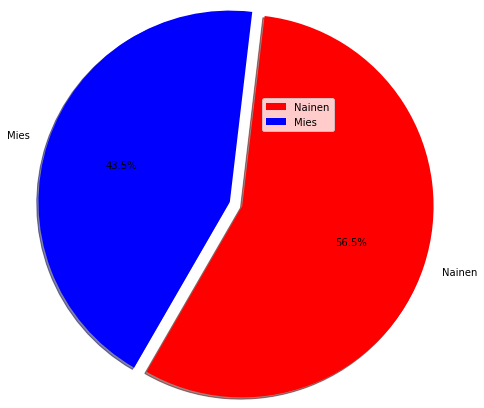

In [20]:
#@title
kyy =  nimet_df.iloc[:,-1]
naiset = len(nimet_df.loc[kyy == 'nainen'])
miehet = len(nimet_df.loc[kyy =='mies'])

#naiset = len(naiset)
#miehet = len(miehet)

sukpl = ['Nainen', 'Mies']
palat = [naiset, miehet]
varit = ['r', 'b']

plt.pie(palat, labels = sukpl, colors=varit, 
        startangle=600, shadow = True, explode = (0.15, 0),
        radius = 2.2, autopct = '%1.1f%%')
  
plt.legend()
plt.show()

### Seuraavaksi esikäsitellään aineisto neuroverkolle ymmärretäään muotoon (nimet numerolistoiksi, sukupuoli numeroksi).

> *TersorFlow tarjoaa mahdollisuuden myös siihen, että esikäsittely tehdään omana neuroverkkokerroksena. Tässä työssä tekniset taidot eivät riittäneet tällaiseen koneoppimismallin toteutukseen, joten edetään osin manuaalisena työskentelynä.*

**Aineiston käsittely toteutetaan omana funktionaan, joka koostuu viidestä vaiheesta:**

1.   Kirjainten käsittely pieneksi, tähän käytetään str.lower() metodia.
2.   Käsitellään merkkijono kirjainlistaksi.
1.   Nimien pituus, tässä vaiheessa nimet ovat jo merkkijonolistoja, joiden mitta yhteismitallistetaan niin että kaikki nimet ovat 50 merkkiä pitkiä. Niiltä osin kuin nimi on lyhyempi, se täytetään loppupäästä lähtien välilyönnillä.
2.   Kirjainten muuttaminen numeroiksi ord() metodilla
1.   Taulukossa sukupuolen koodaaminen numeroiksi "nainen" tai "mies" määrityksen sijaan. Huomattavaa, että tämä on erotettu funktiossa if train -ehtolauseen alle, koska tätä osiota käytetään opetus ja testiaineiston käsittelyssä, mutta ei luonnollisestikaan silloni kun ohjelmaa käytetään nimen testaukseen.

In [ ]:
#@title
def preprocess(nimet_df, train=True):
    # 1. Kirjainten käsittely, kaikki kirjaimet pieneksi
    nimet_df['Etunimi'] = nimet_df['Etunimi'].str.lower()

    # 2. Merkkijono erotellaan kirjainlistaksi
    nimet_df['Etunimi'] = [list(name) for name in nimet_df['Etunimi']]

    # 3. Muunnetaan kaikki nimet saman mittaiseksi, mitta on 50 merkkiä (täytetään tyhjällä)
    nimi_pituus = 50
    nimet_df['Etunimi'] = [(nimi + [' ']*nimi_pituus)[:nimi_pituus] 
        for nimi in nimet_df['Etunimi']]

    # 4. Muutetaan kirjaimet numeroiksi, jotta neuroverkko voi käsitellän niitä
    # Pythonin metodi ord() kääntää kirjaimet numeroiksi
    nimet_df['Etunimi'] = [[max(0.0, ord(char)-96.0) for char in nimi]
        for nimi in nimet_df['Etunimi']]
    
    if train:
        # 5. Muunnetaan sukupuoli numeroksi (nainen = 0.0, mies = 1.0)
        nimet_df['Sukupuoli'] = [0.0 if sukupuoli == 'nainen' else 1.0 for sukupuoli in nimet_df['Sukupuoli']]
    
    return nimet_df

nimet_df = preprocess(nimet_df)
nimet_df.head(10)  # Tulostetaan head metodilla 10 ensimmäistä riviiä aineistosta tarkasteluun. 

,Etunimi,Sukupuoli
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
4,"[1.0, 1.0, 2.0, 5.0, 12.0, 0.0, 0.0, 0.0, 0.0,...",1.0
5,"[1.0, 1.0, 2.0, 18.0, 1.0, 8.0, 1.0, 13.0, 0.0...",1.0
6,"[1.0, 1.0, 2.0, 18.0, 1.0, 13.0, 0.0, 0.0, 0.0...",1.0
7,"[1.0, 1.0, 2.0, 18.0, 1.0, 13.0, 9.0, 0.0, 0.0...",1.0
8,"[1.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
9,"[1.0, 1.0, 4.0, 1.0, 0.0, 1.0, 13.0, 1.0, 14.0...",0.0



*Esikäsittely, koska esikäsittely tapahtui erillisellä funktiolla ei se muodosta neuroverkkoon omaa kerrosta.*

*Huom! Tässä vaiheessa nimet ovat numerolistoja.*

## **Neuroverkon malliarkkitehtuuri:**

Kyseessä on kaksisuuntainen pitkä lyhytkestomuisti neuroverkko (wikipedia kertoo) LSMT

*   Upotuskerros(Embedding): 

> "upottaa" jokaisen numeron tiheään 256 ulottuvuuden vektoriin. Valinta embedding_dim on hyperparametri, jota voidaan virittää haluttuun tarkkuuteen.


*   Kaksisuuntainen LSTM-kerros(Bidirectional LSTM): 

> lukee merkkien upotusten sarjat edellisestä vaiheesta ja tulostaa vektorin, joka edustaa tätä sarjaa. Yksiköiden ja poistuneiden arvot ovat hyperparametreja.

*   Ulostulokerros (Dense): 

> tuottaa yhden arvon, joka on lähellä 0:ta Naiselle tai lähellä 1:tä Miehelle.


Lisäksi mallissa käytetään optimointia harjoituskierrosten määrän osaslta, jotta vältyttäisiin yli- tai alisovittamiselta. 

Mallin funkioi luodaan tässä ja ajetaan sitten seuraavassa vaiheessa.

In [ ]:
#@title
def lstm_model(num_alphabets=256, nimi_pituus=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=nimi_pituus),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

Seuraavassa kohdassa: 
 
*   Aineisto jaetaan harjoitus- ja testiaineistoihin.
*   Määritetään harjoituksen aikaisemman päättämisen perusteet (optimointi)
*   Harjoitetaan aineisto, laitetaan valtava määrä harjoituskierroksia (50), koska optimointi huolehtii harjoittelun lopettamisesta.
*   **Tallennetaan malli myöhempää käyttöä varten** 
> Mallin harjoittaminen on kestänys minulla vaihtelevasti noin 1,5 tuntia. On siis hyvin olennaista tallentaa malli, jotta sit ei tarvitse joka kerta ajaa uudelleen!

   > => Tallennettu malli toimii myös omalla koneella, mikäli kaikki tarvittavat kirjastot on käytettävissä. Tässä projektityössä mallin varsinainen käyttö on tehty erilliseen työkirjaan.






In [ ]:
#@title

# num_alphabets oli alkuperäisessä mallissa vain 27, mutta en saanut sellaisin tiedoin toimiaan, 
# arvelin johtuvan äöå -kirjaimista, mutta ei onnistuneet ajot muutoin kuin asettamalla kirjainmäärä samaksi 
# kuin embedding_dim. Tarkkaan en osaa tätä perustella.

model = lstm_model(num_alphabets=256, nimi_pituus=50, embedding_dim=256)

# Jaetaan aineisto harjoitus- ja testiaineistoihin.
X = np.asarray(nimet_df['Etunimi'].values.tolist())
y = np.asarray(nimet_df['Sukupuoli'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Mallin harjoittaminen
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1)
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

# Step 4: Tallennetaan malli erilliseen tiedostoon myöhempää käyttöä varten.
model.save('kumpisukupuoli.h5')

[[16.  5. 14. ...  0.  0.  0.]
 [ 3.  8. 18. ...  0.  0.  0.]
 [13.  1. 10. ...  0.  0.  0.]
 ...
 [10. 15. 19. ...  0.  0.  0.]
 [11.  1. 26. ...  0.  0.  0.]
 [ 1. 19. 20. ...  0.  0.  0.]]
Epoch 1/50
287/287 [==============================] - 223s 754ms/step - loss: 0.5341 - accuracy: 0.7142 - val_loss: 0.4910 - val_accuracy: 0.7562
Epoch 2/50
287/287 [==============================] - 212s 738ms/step - loss: 0.4651 - accuracy: 0.7669 - val_loss: 0.4589 - val_accuracy: 0.7791
Epoch 3/50
287/287 [==============================] - 223s 779ms/step - loss: 0.4390 - accuracy: 0.7836 - val_loss: 0.4380 - val_accuracy: 0.7850
Epoch 4/50
287/287 [==============================] - 226s 789ms/step - loss: 0.4240 - accuracy: 0.7954 - val_loss: 0.4290 - val_accuracy: 0.7970
Epoch 5/50
287/287 [==============================] - 226s 789ms/step - loss: 0.4083 - accuracy: 0.8026 - val_loss: 0.4045 - val_accuracy: 0.8073
Epoch 6/50
287/287 [==============================] - 231s 805ms/step - loss: 

Alla tarkastellaan harjoituksen etenemistä graafisesti. Sinisellä viivalla on merkitty kuinka hyvin malli on selvinnyt harjoitusaineiston kanssa ja oranssilla viivalla on kuvattu mallin selviytymistä validoinnissa (testiaineistolla).

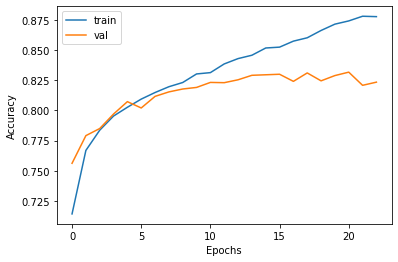

In [ ]:
#@title
# Step 5: Tarkkuuksien kehittyminen mallin kouluttamisen myötä
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#**Malli on luotu, koulutettu ja tallennettu. Oppimiskäyräkin näyttää olevan ihan ok.**

# Kokeillaan mallia, miten se toimii. Tässä vaihessa syötetään valmis nimilista ja muotoillaan tulostus.

> 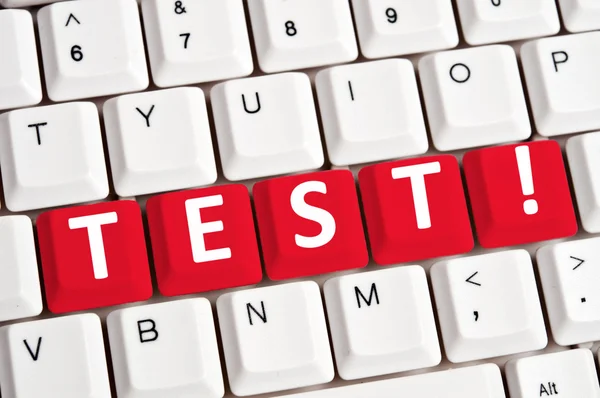

## Mallin testaaminen itse. 

Malli on omana tiedostonaan ja sinänsä käyttökelpoinen millä tahansa koneella myös paikallisesti, mikäli koneelle on asennettu riittävät Tensorflow kirjastot.

Ohjelman käyttäminen paikallisesti vaatii mallin lisäksi esikäsittelyfunktion sisältämän tiedoston tallentamista ja tuomista koodiin.

In [ ]:
#@title
# Tuodaan load_model metodi kerasin kirjastosta
# Tarvitemme myös Pandasin ja numpyn mallin käyttöön. 
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# Ladataan tallennettu ja opetettu malli
pred_model = load_model('/content/kumpisukupuoli.h5') 

# Syötetään testattavat nimet
nimet = ['Irma', 'Arto', 'Venla', 'Edwart'] 

# Muunnetaan nimet Pandas taulukoksi
pred_df = pd.DataFrame({'Etunimi': nimet})

# Esikäsitellään nimet samalla tavalla kuin opetusaineiston nimet esikäsiteltiin (valmis funktio  tähän)
pred_df = preprocess(pred_df, train=False)

# Ennustetaan mallilla 
result = pred_model.predict(np.asarray(
    pred_df['Etunimi'].values.tolist())).squeeze(axis=1)

## MÄÄRITETÄÄN TIETOJA MITEN ENNUSTE TULOSTETAAN:

# Määritetään, että mies, mikäli logit on yli 0.5
pred_df['Naisen vai miehen?'] = [
    'Mies' if logit > 0.5 else 'Nainen' for logit in result
]
# Tulostetaan todennäköisyys
pred_df['Todennäköisyys'] = [
    logit if logit > 0.5 else 1.0 - logit for logit in result
]

# Format the output
pred_df['Etunimi'] = nimet
pred_df.rename(columns={'name': 'Name'}, inplace=True)
pred_df['Todennäköisyys'] = pred_df['Todennäköisyys'].round(2)
pred_df.drop_duplicates(inplace=True)

pred_df

1/1 [==============================] - 1s 958ms/step


,Etunimi,Naisen vai miehen?,Todennäköisyys
0,Irma,Nainen,0.91
1,Arto,Mies,0.99
2,Venla,Nainen,0.98
3,Edwart,Mies,1.00


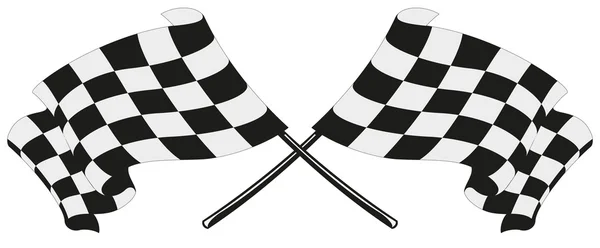

# **Jälkipyykit Projektista**


1.   Vaikea alku, eikä niin helppo jatkokaan
2.   ChatGPT apuna koodauksessa
3.   Huomioita, parannettavaa
4.   Projektityö oppimisprosessina




## 1. Vaikea alku, eikä niin helppo jatkokaan

Projektityö lähti käyntiin valtavalla innolla ja onnistumisen uholla. Noh, näitä tunteita koiteltiin matkan varrella useaan otteeseen.

Halusin tehdä neuroverkon
1. Täysin itse TensorFlow:n ohjeiden pohjalta
2. "Tyylipuhtaasti" käyttäen kattavaa mallia ilman käsipelillä tapahtuvia aineistojen muokkauksia.

Toisin kävi. 

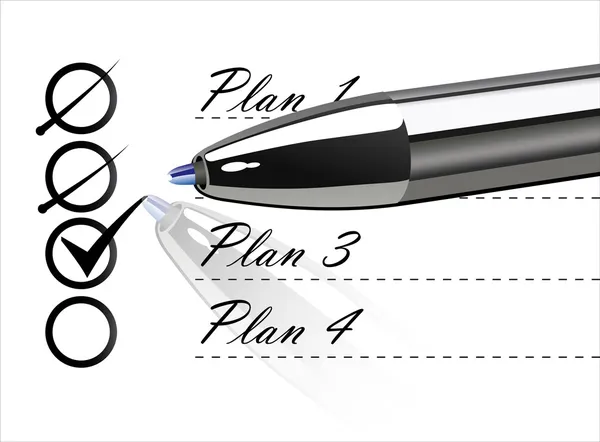

Projektin alussa uppouduin lukemaan TensorFlown ohjeita. Välillä arvelin olevani oikeilla jäljillä ja välillä taas huomasin olevani täysin hukassa. 

Suuri haaste alkumetreillä oli se, että kaikki ohjeet tuntuivat käsittelevän malleja, jotka tehdään tensorflown omilla aineisteilla. Jotenkin onnistuin datasetin tekemisestä saamaan miltei tekemättömän paikan. Ehkä sellainen norsunsyönti kerrallaan tilanne.

En näin jälkikäteen oikein edes ymmärrä miten onnistuin saamaan pään niin pyörälle, että pääsi jo läikähtämään aivovuotona yli sellainen pieni juttu, että minullahan on aineistossani tasan kahta tietoa: nimi ja sukupuoli, jälkimmäinen näistä on labeli. Voi ilon ja onnen päivää kun tämän taas tajusin. 

Rakensin (teknisesti kai lopulta lähes onnistuneesti) neuroverkon ensimmäistä kerrosta, joka käsittelee nimet vektoreiksi ja onnistuin tähän jollain tapaa nimilistat adaptoimaankin. Mutta mallia en saanut tehtyä. Tuohon oli jo niin paljon käytettynä aikaa, onnistumisia, epäonnistumisia, umpikujia jne 

ChatGPT:n suosiollisella avustuksella sain myös yhden teknisesti toimivan mallin rakennettua, mutta se ei paljon arvausta paremmin toiminut - ei käy. Paikansin ongelman tokenisointiin. 

Yritin yhdistää omaa mallia ja ChatGPT:n johtamaa mallia onnistumatta. Olisihan se ollut riemuvoitto, minä sain hyvän alun ja tekoäly auttoi toimivan lopun kanssa. 

Aikataulu alkoi painaa jo siinä määrin, että lähdin tekemään mallia valmiin girl or boy -ohjelman esittelyn pohjalta. Toimivan mallin sain aikaan kohtalaisen nopeasti, kopioinnin lisäksi tarvitsin vain pientä säätöä ja muutoksia. Myöhemmin olen säätänyt vielä vähän lisää. Mutta runko on muualta, se ei ole omaa käsialaa. Autsh, tämä lienee projektin suurin takaisku.

Sen jälkeen kun linjasin, että nyt on mentävä valmiilla mallilla tai minulla ei ole toimivaa ohjelmaa homma on sujunutkin sitten paremmin. Tappion karvasta kalkkia samalla nieleskellen. 

Valmiin rungon  komennot ja koodi oli kuitenkin todella helppo ymmärtää ja omaksua heti ekasta lukukerrasta lähtien - kyllä vain, TensorFlown sivustoilla vietetty aika ei ole mennyt täysin hukkaan. 

Mallin säätämisen/ omien kokeilujen haaste loppuvaiheessa oli ehtyvä aika sekä se yllättävä asia, että mallin opettaminen kesti pitkästi toista tuntia! Ei ihan kamalan montaa kertaa viitsi ajella, muutaman kerran oli pakko... tai pakko ja pakko, ihan omaa huomimattomuutta.

Lopussa tein vielä raportointia, tämäkin otti aikansa. Colab on mahtava työkalu, paitsi silloin kun se menee jumiin. 

Raportointivaiheessa vasta lisäsin aineiston jakautumiseen naisten ja miesten nimiin liittyvän graafisen esitysmuodon, tässä kohtaa aivan harmitti kun tuolla kirjastossahan olisi vaikka ja mitä mahdollisuuksia käytettävänä. Noh, hyvä kun tuli kosketuspintaa niin ehkä joskus, jossain harrastelussa niihin paneudun.

Samoin colabin ominaisuudet alkavat tässä pikkuhiljaa aueta ja saahan nähdä, täällä voisi ehkä jotain pientä data-analytiikkaa harrastella joskus myöhemminkin.



## 2. ChatGPT apuna koodauksessa

Paljon hyvää ja hyödyllistä, mutta yhtä paljon ansoja.

Pyysin ChatGPT:ta apua projektin alkumetreillä. Sain kyllä valmista koodia, mutta ei kokemukseni mukaan toimivaa koodia tähän tarkoitukseen.

Myöhemmin pyydetty malli korjauksineen (osin itse korjattu, osin pyydetty korjauksia ChatGPT:lta) teknisesti ottaen toimi eli koodin sai ajettua Colabissa, mutta malli oli heikko. Mallissa ilmeni ongelmaa tokenisoinnissa ja osa kirjaimista jäi tyhjiksi eikä ne näin erottuneet toisistaan. Oletettavasti tämän vuoksi malli pääsi onnitusmisissa vain 58 prosenttiin, kun lopullinen malli yltää reilusti yli 80 % (mallin menestys on vaihdellut vähän eri ajokerroilla).



**Miten valjastaa ChatGPT hyötykäyttöön, omia ajatuksia**

1. Kysy apua umpikujatilanteissa ja hyödynnä lisäkysymysten mahdollisuutta. Näin pääsee eteenpäin ja ainakin omalla kohdallani myös omien ajatusten vaihtoehtoisten ratkaisumallien idointi sai uutta boostia.
2. Voit kysyä valmista mallia, mutta todennäköisesti et saa täysin omia tarpeita vastaavaa ratkaisua. Kuitenkin ChatGPT:n tarjoaman ratkaisun ymmärtäminen ja omaksuminen voi auttaa eteenpäin.
3. ChatGPT on avustaja ja työkaveri, se voi auttaa eteenpin muttei ratkaise työtäsi.
4. Hyödynnä sillon kun työssä on paljon epäselvyyttä ja outoja asioita, ChatGPT:n koodin kautta voit löytää langanpäitä, joita lähteä seuraamaan.
5. Hyödynnä täsmällisissä ongelmakohdissa tarkoilla kysymyksillä ja ohjelma auttaa ratkaisun polulle - tai sitten ei auta.

ChatGPT ei vapauta lukemasta kirjastojen ohjeita eikä se osaa täysin neuvoa soveltuuko ehdotettu ratkaisu ongelmaasi.

Jokaisesta ChatGPT:n antamasta koodista olen joutunut vähinkäänkin kirjoitusvirheitä korjaamaan, joten vielä ei ole tällä saralla läpimurtoa siinä, että koodaus olisi nyt kaikkien ulottuvilla ilman lähtötasovaatimuksia.


## 3. Huomioita, parannettavaa prosessissa, mallissa tai aineistossa

**Mitä tekisin toisin jos nyt aloittaisin projektin?**

> Lähtökohtaisesti en tiedä valitsisinko sittenkin helpomman projektityön aiheen =)

> Määrittäisin tarkemmin, että minkälaisesta tehtävästä ja aineistosta on kyse. Ja kävisin TensorFlown ohjeita läpi tästä näkökulmasta.

> Valitsisin toimintamallit ja varhaisessa vaiheessa varmistaisin ohjaajalta, että vaikuttaisiko suunta oikealle. 

> Hampaankoloon jäi kaivelemaan se, että en saanut tehdyä tuota tekstin esikäsittelyä neuroverkon ensimmäisenä kerroksena, vaan tein sen manuaalisesti (samoin aineiston esikäsittelyä jo CSV tiedostoon manuaalisesti)

> Aika oli minulle riittämätön tässä projektissa. Olisi voinut heti alusta lähteä toteuttamaan tätä valmistakin mallia ja silti olisi ollut riittävän haastavaa. Tosiaalta, en osaa arvioida paljonko oppia on tarttunu TensorFlown sivuilla seikkaillessa, siellä kuitenkin pitkälsi kaksi kolmasosaa projektin ajasta on kulunut. Ainakin englanniksi lukeminen helpottui loppua kohti =)


**Aineiston käsittelyn heikkoudet.**

> Loppuvaiheessa jäin pohtimaan, että minulla oli vain opetusaineisto ja testiaineisto, jota käytettiin mallin validointiin. TensorFlown useissa ohjeissa kuitenkin suositeltiin jakamaan aineisto harjoitusaineistoon ja testiaineistoon sekä näistä harjoitusaineisto edelleen harjoitus ja validointiaineistoihin. 

> Saatan vielä kurssin jälkeen testailla tuota mallia eri opetusaineistoilla (jätän pois harvinaiset nimet rajoilla 100, 200 ja 500. Lopulta pääsee hyvin yleisiin nimiin, mutta aineisto suppenee murto-osaan)


## 4. Projektityö oppimisprosessina

Projekti oli mielenkiintoinen ja lievästi sanoen mukaansatempaava. Tunnemyrskyjä tuli niin innostumisen, onnistumisen, epäonnistumisen kuin turhautumisenkin kanssa. Eipä olisi niin heilautellu jos ei olisi niin tahtonut onnistua ja osata =)

Erittäin keskeinen oppi tässä prosessissa minulle oli se, että tiedonhakuun ja asioihin perehtymiseen tulee varata paljon aikaa. Mitä oudompi asia, sitä enemmän tarvitaan aikaa. Ehkä lähtötilanteessa ajatus omasta osaamisesta ja ymmärryksestä oli livästi sanottuna yliarvioitu. 

> **Muistilappu itselle:** 
> Varaa riittävästi aikaa tiedonhaulle ja hyödynnä ohjauksen mahdollisuus. Kuten koodauksessa, tiedonhaussa ja opettelussakin lienee sama viisaus: arvioitu aika kertaa kolme on todennäköisesti riittävä aika-arvio. 

Pahimmissa jumitilanteissa parityöskentely ja ryhmän tuki avaa omaa aivoummetusta huomattavasti, saattaapi jopa päästä taas uuteen innostusvauhtiin. Ongelmanratkaisutyössä tämä on ihan ehdotonta. Vastaavanlaisen projektin osalta näkisin, että olisi hyödyllistä työskennellä parin kanssa erityisesti jos asia sovelletaan asiaa, jota ei vielä edes osaa. Luonnollisesti ryhmä- tai parityö vaatii motivaatiota kummaltakin ponnsitella. Mutta asioiden pallottelu ja pähkäily yhdessä tehostaa oppimista hurjasti. - nimimerkillä TensorFlown ohjeiden parissa toisinaan täysin ulapalla ollut.

On todettava, että olen itse pettynyt projektityön lopputulokseen mallin osalta. Se on miltei kopio valmiista mallista. Toisaalta kuitenkin, olen oppinut matkan varrella ihan valtavan paljon enkä tiedä olisinko projektin alkuvaiheissa osannut toteuttaa edes tuota valmista mallia, sekin kun vaati pientä säätämistä toimiakseen. 

Projekityön loppuvaiheilla asioita alkoi avautua ja loksahdella paikoilleen (tästäkin huolimatta jotain jäi vielä käsittämättäkin).

Tästä projektista jäi reppuun ainakin nämä:

* Osaan ja uskallan käyttää Colabia omiin projekteihin
* Osaan ja rohkenen etsiä niin valmiita tekoälymalleja kuin erilaisia kirjastojakin, joita voisin hyödyntää
* Loppumetreillä Pandas ja Matplotlib kirjastot alkoivat huudella tarkempaan perehtymiseen. Tästä on hyvä jatkaa toisissa hommissa
* Umpisurkea enkkuni kehittyi hurjasti näinkin lyhyen projektin aikana (siis näiden ohjeiden lukemisessa)
* Hämmentävän hyvin tekoäly oppii tunnistamaan sen, kuuluko nimi naiselle vai miehelle. 
* Ehkä se suurin saalis on innostus ja mielenkiinto tekoälyyn =) 
